In [1]:
from selenium import webdriver
import pandas as pd
# import matplotlib
import seaborn as sns # visualization
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
import statistics
import resources # custom libraries
import numpy as np
from tensorflow import keras

## Scrapping the data
- Entering url and stracting data as a Pandas df
- After scrapping the data, df will be stored as CSV file
- If data has been already scrapped, data is stracted from CSV

In [2]:
training = True

if training:
    today = str(datetime.today().strftime('%d-%m'))
    # Getting data
    df = resources.data_scraper.scrape()
    # Casting columns
    df[df.columns[2]] = df[df.columns[2]].astype(np.int64)
    df[df.columns[3]] = df[df.columns[3]].astype(np.int64)
    # Adding total_score column
    df["TotalScore"] = df[df.columns[2]] + df[df.columns[3]]
    # Store CSV
    df.to_csv('data/{}.csv'.format(today), encoding='utf-8', index=False)
else:
    today = '07-05'
    df = pd.read_csv('data/{}.csv'.format(today))

In [3]:
# NON_DESIRED_TEAMS = ['Team Durant','Team LeBron']
# df = df[df[df.columns[0]] != (NON_DESIRED_TEAMS[0] or NON_DESIRED_TEAMS[1])]
# df = df[df[df.columns[1]] != (NON_DESIRED_TEAMS[0] or NON_DESIRED_TEAMS[1])]
len(df) # 833 for today
df.head()

,HomeTeam,AwayTeam,ScoreHome,ScoreAway,TotalScore
0,Golden State Warriors,Oklahoma City Thunder,118,97,215
1,Los Angeles Clippers,Los Angeles Lakers,118,94,212
2,Detroit Pistons,Memphis Grizzlies,111,97,208
3,Indiana Pacers,Atlanta Hawks,133,126,259
4,Dallas Mavericks,Brooklyn Nets,113,109,222


#### Heatmap

In [4]:
# resources.graph.heatmap(df, f_size=10, cmap="afmhot_r",vmin=150, vmax=250)

### Frecuency histogram
- To know how many divisions or 'bins' should be done in the histogram, we must use Sturges law

$$ c = 1 + \dfrac{log(M)}{log(2)}$$

In [5]:
# resources.graph.frecuency_histogram(df)


#### Boxplot

In [6]:
# plt.boxplot(df['TotalScore'])
# plt.title("Total score distribution")

#### Normal dfistribution

In [7]:
# resources.graph.normal_distribution(df, 'Atlanta Hawks')

## Data analysis
- Analysing data
- Store results in a new df

In [8]:
stats_df = resources.nba_stats.stats(df)
stats_df.head()

,team,mean,P25,P75,factorDown,factorUp,WfactorDown,WfactorUp
0,Golden State Warriors,225.449275,214.0,234.0,1.449275,13.043478,2.876025,93.051634
1,Los Angeles Clippers,221.742857,210.0,234.0,8.571429,8.571429,58.281345,53.724774
2,Detroit Pistons,214.701493,201.0,224.5,14.925373,5.970149,111.063811,32.789787
3,Indiana Pacers,228.285714,214.0,243.0,9.523810,20.634921,43.107490,201.228233
4,Dallas Mavericks,221.955224,210.0,236.0,13.432836,8.955224,89.239944,111.804113


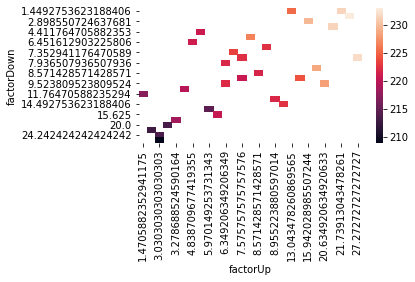

In [9]:
x_col = "factorDown"
y_col = "factorUp"
z_col = "mean"

# fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
sub_df = stats_df.loc[:, [x_col, y_col, z_col]]
# sub_df.drop_duplicates(subset=x_col, inplace=True)
# sub_df.drop_duplicates(subset=y_col, inplace=True)
pivoted = sub_df.pivot(x_col, y_col, z_col)

ax = sns.heatmap(pivoted)


plt.tight_layout()
plt.show()



## Prepare data

In [10]:
# Extract X, deleting non desired attributes
def replace_teams(df, stats_df):
    merged = pd.merge(left=df.iloc[:, :2], right=stats_df, how='inner',
                     left_on='HomeTeam', right_on='team')

    merged = pd.merge(left=merged, right=stats_df, how='inner',
                     left_on='AwayTeam', right_on='team')

    X = merged.iloc[:, np.r_[3:10, 11:18]]

    return X

In [11]:
X = replace_teams(df, stats_df)
X.head()

,mean_x,P25_x,P75_x,factorDown_x,factorUp_x,WfactorDown_x,WfactorUp_x,mean_y,P25_y,P75_y,factorDown_y,factorUp_y,WfactorDown_y,WfactorUp_y
0,225.449275,214.0,234.0,1.449275,13.043478,2.876025,93.051634,219.761194,208.5,230.0,10.447761,4.477612,131.601979,38.008678
1,221.742857,210.0,234.0,8.571429,8.571429,58.281345,53.724774,219.761194,208.5,230.0,10.447761,4.477612,131.601979,38.008678
2,221.742857,210.0,234.0,8.571429,8.571429,58.281345,53.724774,219.761194,208.5,230.0,10.447761,4.477612,131.601979,38.008678
3,214.701493,201.0,224.5,14.925373,5.970149,111.063811,32.789787,219.761194,208.5,230.0,10.447761,4.477612,131.601979,38.008678
4,228.285714,214.0,243.0,9.523810,20.634921,43.107490,201.228233,219.761194,208.5,230.0,10.447761,4.477612,131.601979,38.008678


In [12]:
y = df['TotalScore'].values
y = y.astype(np.float64)
y = y.reshape(-1, 1)

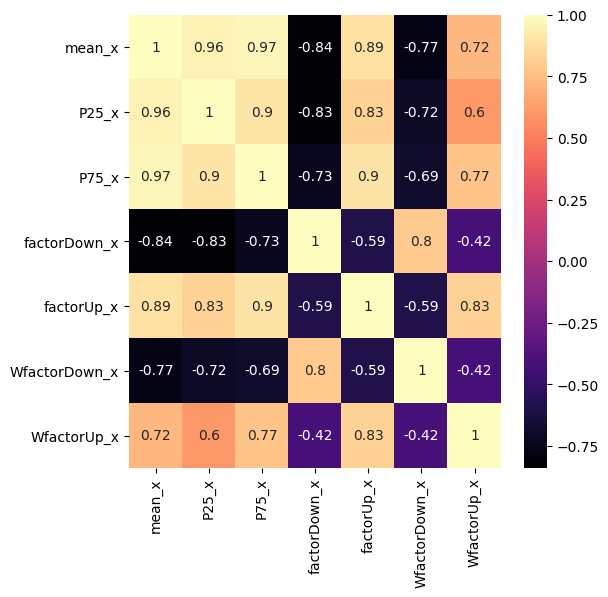

In [13]:
f_size = 6
plt.figure(figsize=(f_size,f_size), dpi=100)
sns.heatmap(X.iloc[:,:7].corr(), annot = True, cmap = 'magma')
plt.show()

In [14]:
# Normalize data
from sklearn.preprocessing import MinMaxScaler, normalize
# fit scaler on training data
x_scaler = MinMaxScaler().fit(X)
# transform training data
X_norm = x_scaler.transform(X)

y_scaler = MinMaxScaler().fit(y)
y_norm = y_scaler.transform(y)


In [74]:
# Create training and validations sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.15, random_state=42)

## Training model

In [110]:
if training: # Train the model 
    # Create you neural net
    from keras.models import Sequential
    from keras.layers import Dense
    from numpy.random import seed
    seed(21)
    # from tensorflow import set_random_seed
    from tensorflow import random
    random.set_seed(21)
    # Model params
    input_dim = X.shape[1]
    out_size = y.shape[1]

    model = Sequential()
    model.add(Dense(16, input_dim=input_dim, activation='relu', kernel_initializer='he_uniform')) # 14
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
    # model.add(Dense(8, activation='relu'))
    model.add(Dense(out_size, activation='relu', kernel_initializer='he_uniform'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Train the model
    model.fit(X_norm, y_norm, epochs=100, batch_size=16, shuffle=True, verbose=2);
    
    # Store model
    model.save('./models/MLP/{}'.format(today))
else:
    model = keras.models.load_model('./models/MLP'.format(today))


## Evaluate model

In [108]:
predictions = model.predict(X_test)
predictions = y_scaler.inverse_transform(predictions)
y_test_deno = y_scaler.inverse_transform(y_test)

data = np.concatenate((y_test_deno, predictions), axis=1)

# comparation = pd.DataFrame({'TrainSet': y_train_deno[:5], 'Prediction': predictions[:5]})
comparation = pd.DataFrame(data=data, columns=["Train", "Prediction"])
comparation['Prediction'] = comparation['Prediction'].round()
comparation['Error'] = abs(comparation['Train'] - comparation['Prediction'])
comparation = comparation.astype('int32')

print('The maximum error:', comparation['Error'].max())
print('The average error:', round(comparation['Error'].mean(),2))
print('The dispersion of data:', round(comparation['Error'].std(),2))

print('Range of training set from {} to {}'.format(round(y_test_deno.max()), round(y_test_deno.min())))
print('Range of prediction set from {} to {}'.format(round(predictions.max()), round(predictions.min())))
#57,14,11
comparation.head()

The maximum error: 45
The average error: 12.47
The dispersion of data: 9.48
Range of training set from 273 to 175
Range of prediction set from 255 to 208


,Train,Prediction,Error
0,214,215,1
1,223,225,2
2,239,217,22
3,232,226,6
4,233,215,18


## Predicting data

In [124]:
future_games = [
    ['DET', 'PHI', 218],
    ['WAS', 'IND', 248],
    ['MEM', 'TOR', 227],
    ['BKN', 'DEN', 232],
    ['HOU', 'UTA', 226],
    ['OKC', 'GS', 224],
    ['SA', 'POR', 232],
#     ['LAL', 'POR', 222],
#     ['NY', 'PHX', 217],
#     ['SA', 'SAC', 223],
]

new_games = pd.DataFrame(columns = ['HomeTeam', 'AwayTeam', 'BetScore'])
               
for game in future_games:
    home_team = resources.teams.conversion_dict[game[0]]
    away_team = resources.teams.conversion_dict[game[1]]
    game = [home_team, away_team, game[2]]
    resources.df_helper.append_row(new_games, game)
    
today_games = replace_teams(new_games, stats_df)
today_games_norm = x_scaler.transform(today_games)

predictions = model.predict(today_games_norm)
decoded_predictions = y_scaler.inverse_transform(predictions)

# Round and cast to integer
new_games['Predictions'] = np.rint(decoded_predictions).astype('int16')
new_games['Confidence'] = abs(new_games['BetScore'] - new_games['Predictions'])

# Safe bets
# new_games = new_games[(new_games['Confidence'] >= 5) & (new_games['Confidence'] <= 15)]

new_games

,HomeTeam,AwayTeam,BetScore,Predictions,Confidence
0,Detroit Pistons,Philadelphia 76ers,218,223,5
1,Washington Wizards,Indiana Pacers,248,226,22
2,Memphis Grizzlies,Toronto Raptors,227,226,1
3,Brooklyn Nets,Denver Nuggets,232,217,15
4,Houston Rockets,Utah Jazz,226,204,22
5,Oklahoma City Thunder,Golden State Warriors,224,220,4
6,San Antonio Spurs,Portland Trail Blazers,232,228,4
